# Chamber Forward Simulation

Comprehending particle dynamics within controlled environments is fundamental for the precise interpretation of experimental measurements. An aerosol chamber forward simulation is an approach employed to analyze and predict the behavior of particles under laboratory conditions. This method enables us to construct a virtual representation of the chamber dynamics, providing a platform to systematically examine the influence of different physical and chemical processes on aerosol populations. Specifically, we focus on three key processes: chamber aerosol dilution, particle coagulation, and wall loss (deposition). Each of these plays a pivotal role in shaping the size distribution of particles:

- **Chamber Aerosol Dilution**: Dilution refers to the reduction in particle concentration due to the introduction of clean air into the chamber. This process can lead to a decrease in the overall number of particles without altering the size distribution significantly. However, it can indirectly influence the dynamics of coagulation and deposition by changing the particle concentration.
- **Particle Coagulation**: Coagulation is the process where particles collide and stick together, forming larger particles. This leads to a shift in the size distribution towards larger sizes, reducing the number of smaller particles and increasing the average size of particles in the chamber. Coagulation is particularly significant for smaller particles due to their higher Brownian motion and likelihood of interaction.
- **Wall Loss** (Deposition): Wall loss occurs when particles deposit onto the walls of the chamber, removing them from the airborne population. This process preferentially affects larger particles due to their greater settling velocity and can lead to a decrease in the overall number of particles and a subtle shift in the size distribution towards smaller sizes.

We'll be running a simulation of a chamber experiment, and turn on/off each of these processes to see how they affect the size distribution of particles. We'll also be able to see how the size distribution changes over time as the experiment progresses.

The initial `particula` imports are next.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Importing 'u' from particula, which is a units tracker using the pint
# library. It helps in managing units throughout the calculations,
# ensuring consistency and correctness.
from particula import u

# Importing 'Solver' from particula.dynamics. This is an integrated scipy
# ode (ordinary differential equation) solver customized for solving the
# dynamics of particles in aerosol science. It includes various processes
# like coagulation, condensation, nucleation, and more.
from particula.dynamics import Solver

# Importing 'particle' from particula. This module deals with particle
# distribution and properties. It is used to define the particles,
# including their size, number, and other characteristics necessary for
# the chamber simulation.
from particula import particle


## Initial Simulation Setup

In this section, we define the initial conditions and parameters for our chamber simulation. The `simple_dic_kwargs` dictionary contains all the necessary parameters to initialize our particle distribution within the chamber. Here's a breakdown of each parameter:

- mode: The median diameter of the particles, set to 100 nm (or 200 nm median diameter).
- nbins: The number of bins for the particle size distribution, set to 500. This parameter defines the resolution of our size distribution.
- nparticles: The total number of particles, set to 50,000. This value is crucial for determining particle concentration and interaction rates.
- volume: This parameter represents the volume occupied by the particles, not the total volume of the chamber.
- gsigma: The geometric standard deviation of the particle size distribution, set to 1.5. This parameter describes the width of the size distribution.
- dilution_rate_coefficient: The rate at which particles are diluted due to the introduction of clean air, set to 0.1 per hour.
- wall_loss_approximation: The method used to approximate wall loss, set here as "rectangle". This parameter influences the surface area that particles are lost to the chamber walls.
- chamber_dimension: The dimensions of the chamber, set to 0.25m x 0.25m x 1.6m. The size and shape of the chamber can significantly affect particle dynamics.
- chamber_ktp_value: The rate of wall eddy diffusivity, set to 0.2 s⁻¹. This parameter is part of modeling how particles interact with the chamber walls.

We initialize the particle distribution with these parameters using particle.Particle(**simple_dic_kwargs). Next, we define the time_array using numpy.linspace to simulate 1 hour divided into 100 steps. This array represents the simulation time for our dynamics.

Finally, we set up and run the dynamics solver. We pass in our particle distribution and specify which processes to include in our simulation. Here, we're focusing on coagulation (`do_coagulation=True`) and excluding other processes like condensation, nucleation, dilution, and wall loss for simplicity. The solver uses the odeint method to integrate the dynamics over the specified time array, producing the solution_coag, which is the result of our simulation and will be used for analysis and visualization.

In [2]:
# Define initial simulation parameters
simple_dic_kwargs = {
    "mode": 100e-9,  # Median diameter of the particles in meters
    "nbins": 500,  # Number of bins for size distribution
    "nparticles": 5e4,  # Total number of particles
    "volume": 1e-6,  # Volume occupied by particles in cubic meters (1 cc)
    "gsigma": 1.5,  # Geometric standard deviation of particle size distribution
    "dilution_rate_coefficient": 0.1 * u.hour**-1,  # Rate of particle dilution
    "wall_loss_approximation": "rectangle",  # Method for approximating wall loss
    # Dimensions of the chamber in meters
    "chamber_dimension": [0.25, 0.25, 1.6] * u.m,
    "chamber_ktp_value": 0.2 * u.s**-1,  # Rate of wall eddy diffusivity
}

# Create particle distribution using the defined parameters
particle_dist = particle.Particle(**simple_dic_kwargs)

# Define the time array for simulation, simulating 1 hour in 100 steps
time_array = np.linspace(0, 60 * 60 * 1, 100)

# Define additional parameters for dynamics simulation
rates_kwargs = {
    "particle": particle_dist,  # pass it the particle distribution
    "lazy": False,  # Disables lazy evaluation for immediate computation
}

# Initialize and solve the dynamics with the specified conditions
solution_coag = Solver(
    time_span=time_array,  # Time over which to solve the dynamics
    do_coagulation=True,  # Enable coagulation process
    do_condensation=False,  # Disable condensation process
    do_nucleation=False,  # Disable nucleation process
    do_dilution=False,  # Disable dilution process
    do_wall_loss=False,  # Disable wall loss process
    **rates_kwargs  # Additional parameters for the solver
).solution(method='odeint')  # Specify the method for solving the ODEs

## Visualization of Particle Size Distribution Over Time

In our chamber simulation, the output solution is a matrix representing the evolution of particle size distribution over time. Specifically, the solution is a 500x100 matrix where each row corresponds to a specific particle size (500 size bins in total), and each column represents the particle distribution at a given time point (100 time steps in total).

The semi-logarithmic plot visualizes how the particle size distribution changes over the course of the simulation. We are focusing on three specific time points to illustrate these dynamics:

- **Initial Distribution**: This is the distribution at the beginning of the simulation (t=0). It sets the baseline for how particles are initially distributed across different sizes.
- **Mid-Time Distribution**: Represents the distribution at a midpoint in time (here, at the 50th time step out of 100). This snapshot provides insight into the evolution of the distribution as particles undergo processes like coagulation, dilution, and wall loss.
- **Final Distribution**: Shows the distribution at the end of the simulation (at the 100th time step). It indicates the final state of the particle sizes after all the simulated processes have taken place over the full time course.

By comparing these three distributions, we can observe and analyze how the particle sizes have coalesced, dispersed, or shifted due to the underlying aerosol dynamics within the chamber.

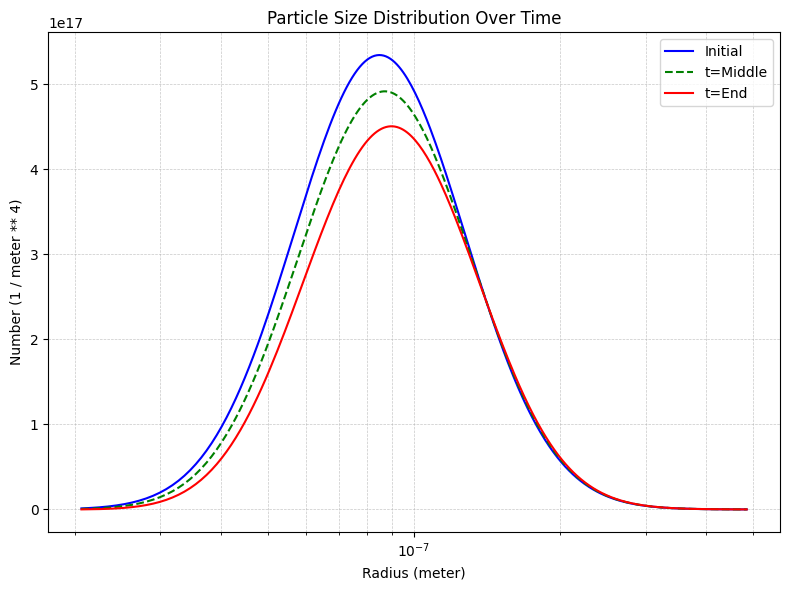

In [7]:
# Plotting the simulation results
# Adjusting the figure size for better clarity
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

# Retrieving the radius and distribution data
radius = particle_dist.particle_radius.m  # Particle radii in meters
# Initial particle distribution
initial_distribution = particle_dist.particle_distribution().m

# Plotting initial, middle, and final distributions as a semi-logarithmic plot
ax.semilogx(radius, initial_distribution, '-b',
            label='Initial')  # Initial distribution
# Mid-time distribution
ax.semilogx(radius, solution_coag.m[49, :], '--g', label='t=Middle')
ax.semilogx(radius, solution_coag.m[-1, :],
            '-r', label='t=End')  # Final distribution

# Enhancing the plot with labels, title, grid, and legend
# X-axis label with units
ax.set_xlabel(f"Radius ({particle_dist.particle_radius.u})")
# Y-axis label with units
ax.set_ylabel(f"Number ({particle_dist.particle_distribution().u})")
ax.set_title("Particle Size Distribution Over Time")  # Title of the plot
ax.grid(True, which="both", linestyle='--', linewidth=0.5,
        alpha=0.7)  # Grid for better readability
ax.legend()  # Legend to identify the lines

fig.tight_layout()  # Adjusting the layout to prevent clipping of labels
plt.show()  # Displaying the plot

### Exploring Variations in Chamber Simulation

We conduct a series of simulations to understand the influence of the three processes on particle behavior. Each simulation activates a different combination of processes, allowing us to isolate and examine their effects on the particle size distribution over time. Below are the variations in simulations conducted:

1. **Simulation with Coagulation and Dilution (`solution_coag_dil`):** 
   - *Processes Included*: Coagulation and Dilution.
   - *Objective*: To observe how particles coalesce into larger sizes due to coagulation and how the overall particle concentration decreases due to dilution. This simulation provides insights into the combined effects of these two processes without the influence of wall loss.

2. **Simulation with Coagulation, Dilution, and Wall Loss (`solution_coag_dil_wall`):**
   - *Processes Included*: Coagulation, Dilution, and Wall Loss.
   - *Objective*: To analyze the cumulative impact of coagulation, dilution, and wall loss on the particle size distribution. This is the most realistic simulation of the three, as it includes all three processes that are typically present in chamber experiments (for non-volatile particles).

3. **Simulation with Dilution and Wall Loss (`solution_dil_wall`):**
   - *Processes Included*: Dilution and Wall Loss.
   - *Objective*: To examine the effects of dilution and wall loss in the absence of coagulation. This simulation is particularly useful for understanding the behavior of larger particles that are more susceptible to wall loss, as well as the general decrease in particle concentration due to dilution.

Each simulation uses the `Solver` class with the Ordinary Differential Equation integration method (`odeint`). By running these simulations and analyzing the resulting particle distributions, we can discern the roles and significances of coagulation, dilution, and wall loss in shaping aerosol populations within controlled chamber environments. These insights are crucial for accurate modeling and prediction of aerosol behavior in both laboratory and atmospheric conditions.

In [8]:
# This simulation includes particle coagulation and dilution from the chamber.
solution_coag_dil = Solver(
    time_span=time_array,
    do_coagulation=True,  # Enable coagulation process
    do_condensation=False,  # Disable condensation process
    do_nucleation=False,  # Disable nucleation process
    do_dilution=True,  # Enable dilution process
    do_wall_loss=False,  # Disable wall loss process
    **rates_kwargs
).solution(method='odeint')

# This simulation includes particle coagulation, dilution, and wall loss
# (deposition).
solution_coag_dil_wall = Solver(
    time_span=time_array,
    do_coagulation=True,  # Enable coagulation process
    do_condensation=False,  # Disable condensation process
    do_nucleation=False,  # Disable nucleation process
    do_dilution=True,  # Enable dilution process
    do_wall_loss=True,  # Enable wall loss process
    **rates_kwargs
).solution(method='odeint')

# This simulation includes only dilution and wall loss (deposition)
# without coagulation.
solution_dil_wall = Solver(
    time_span=time_array,
    do_coagulation=False,  # Disable coagulation process
    do_condensation=False,  # Disable condensation process
    do_nucleation=False,  # Disable nucleation process
    do_dilution=True,  # Enable dilution process
    do_wall_loss=True,  # Enable wall loss process
    **rates_kwargs
).solution(method='odeint')

## Analysis of Simulation Results

The next plot provides a comparative visualization of the particle size distributions resulting from different processes within the aerosol chamber. Each line represents the particle number concentration across a range of particle radii at the end of the simulation period.

- **Initial Distribution (Dashed Blue Line):** This line serves as a reference, illustrating the starting point of the particle size distribution without any dynamic processes affecting it.
- **Coagulation Only (Red Line):** Here, we see the effect of particle coagulation over time. The peak of the distribution shifts slightly towards larger radii, indicating that smaller particles have combined to form larger ones. The number concentration of smaller particles decreases while that of larger particles increases.
- **Coagulation + Dilution (Green Line):** The addition of dilution to coagulation results in an overall lower number concentration across all sizes due to the removal of particles from the chamber. The shape of the distribution still shifts towards larger sizes due to coagulation.
- **Coagulation + Dilution + Wall (Magenta Line):** Incorporating wall loss with coagulation and dilution shows a further decrease in the number concentration of particles, particularly evident in the reduction of the peak. This suggests that larger particles are being lost to the chamber walls, in addition to the effects of coagulation and dilution.
- **Dilution + Wall (Black Line):** This scenario, without coagulation, shows a more uniform reduction in particles across all sizes due to dilution, with a further reduction in larger particles due to wall loss. The peak of the distribution appears to be maintained, indicating that the removal of particles is somewhat consistent across different sizes, though larger particles are slightly more affected by wall deposition.

By examining these lines, we can infer the dominant processes affecting aerosol dynamics and the resultant changes in particle number concentrations as a function of particle size. This analysis is critical for understanding the fate of aerosols in various atmospheric conditions or controlled environments.

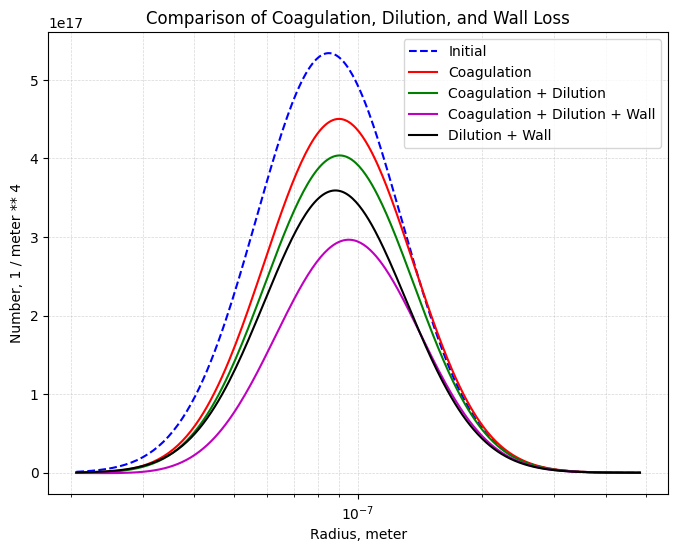

In [10]:
# Plotting to compare the effects of different processes on the final
# particle distribution

# Initialize the figure and axes for the plot with a specified size
fig, ax = plt.subplots(1, 1, figsize=[8, 6])

# Retrieve radius and initial distribution from particle distribution
radius = particle_dist.particle_radius.m  # Particle radii
# Plot the initial distribution as a baseline for comparison
ax.semilogx(
    radius,
    particle_dist.particle_distribution().m,
    '--b',
    label='Initial'
)
# Plot the final distribution after only coagulation
ax.semilogx(
    radius,
    solution_coag.m[-1, :],
    '-r',
    label='Coagulation'
)
# Plot the final distribution after coagulation and dilution
ax.semilogx(
    radius,
    solution_coag_dil.m[-1, :],
    '-g',
    label='Coagulation + Dilution'
)
# Plot the final distribution after coagulation, dilution, and wall loss
ax.semilogx(
    radius,
    solution_coag_dil_wall.m[-1, :],
    '-m',
    label='Coagulation + Dilution + Wall'
)
# Plot the final distribution after dilution and wall loss only
ax.semilogx(
    radius,
    solution_dil_wall.m[-1, :],
    '-k',
    label='Dilution + Wall'
)
# Adding a legend to differentiate between the different scenarios
ax.legend()

# Setting labels and title for the plot
# Y-axis label with units
ax.set_ylabel(f"Number, {particle_dist.particle_distribution().u}")
# X-axis label with units
ax.set_xlabel(f"Radius, {particle_dist.particle_radius.u}")
# Title of the plot
ax.set_title('Comparison of Coagulation, Dilution, and Wall Loss')

# Adding a grid for better readability, particularly on a semilogarithmic plot
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Displaying the plot
plt.show()

## Summary of the Aerosol Chamber Dynamics Notebook

In this notebook, we conducted a series of simulations to study the behavior of aerosol particles within a controlled chamber environment. Our objective was to understand how different processes — namely coagulation, dilution, and wall loss — individually and collectively influence the size distribution of particles over time.

Our simulations revealed several key findings:

- **Coagulation Alone**: When only coagulation was considered, the particle size distribution shifted towards larger particles as expected, since smaller particles tend to combine. However, this view was incomplete as it did not account for other loss mechanisms.
- **Importance of Wall Loss**: The inclusion of wall loss in the simulations proved to be significant. Wall loss, or deposition, especially affected the larger particles due to their higher probability of contact with the chamber walls. This process led to a noticeable reduction in the number concentration of particles, altering the peak and width of the size distribution.
- **Combined Processes**: By simulating a combination of processes, we observed a more complex and realistic representation of particle dynamics. The coagulation plus dilution scenario showed a lower overall concentration across all sizes, while adding wall loss further decreased the number concentration and altered the distribution shape, underscoring the importance of including wall loss in chamber simulations.

The comparison between the different scenarios highlighted that coagulation alone could not fully explain the experimental observations. The absence of wall loss from the simulation would lead to discrepancies when comparing with empirical data, as wall loss is a critical process in chamber dynamics.

Moving forward, our focus will shift towards characterizing a specific chamber. This will involve calibrating our wall loss model to account for the unique physical properties and dynamic behaviors within a particular experimental setup.